# VAE for SMBA

This VAE is adapted from the GM-VAE implementation.

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
num_epochs=10000

## Import Libraries

In [3]:
import json

import numpy as np
import argparse
import random
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.utils.data
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import sys

sys.path.append('../pytorch')
from model.VAE_kld_loss_v2 import *

sys.path.append('../../1906-pcgml/pcgml-gmmVae-exp/modules/')
import vglc_with_path_encodings

## Load data

In [4]:
def open_json_as_nparray(json_fname):
    with open(json_fname, 'r') as json_f:
        return np.array(json.load(json_f))

Load SMB.

In [5]:
smb_int = open_json_as_nparray('smbWithPath-allLevels-chunks-int.json')

In [6]:
smb_onehot = np.eye(len(np.unique(smb_int)))[smb_int]
smb_onehot.shape

(2698, 16, 16, 12)

In [7]:
smb_onehot = smb_onehot.reshape(
    smb_onehot.shape[0], 
    smb_onehot.shape[1] * smb_onehot.shape[2] * smb_onehot.shape[3]
)
smb_onehot.shape

(2698, 3072)

In [8]:
chunks = smb_onehot

## Input Parameters

In [10]:
########################################################
## Input Parameters
#########################################################
parser = argparse.ArgumentParser(description='PyTorch Implementation of DGM Clustering')

## Used only in notebooks
parser.add_argument('-f', '--file',
                    help='Path for input file. First line should contain number of lines to search in')

## Dataset
parser.add_argument('--dataset', type=str, choices=['mnist'],
                    default='mnist', help='dataset (default: mnist)')
parser.add_argument('--seed', type=int, default=1, help='random seed (default: 1)')

## GPU
parser.add_argument('--cuda', type=int, default=0,
                    help='use of cuda (default: 1)')
parser.add_argument('--gpuID', type=int, default=0,
                    help='set gpu id to use (default: 0)')

## Training
parser.add_argument('--epochs', type=int, default=num_epochs,
                    help='number of total epochs to run (default: 200)')
parser.add_argument('--batch_size', default=64, type=int,
                    help='mini-batch size (default: 64)')
parser.add_argument('--batch_size_val', default=200, type=int,
                    help='mini-batch size of validation (default: 200)')
parser.add_argument('--learning_rate', default=1e-3, type=float,
                    help='learning rate (default: 0.001)')
parser.add_argument('--decay_epoch', default=-1, type=int, 
                    help='Reduces the learning rate every decay_epoch')
parser.add_argument('--lr_decay', default=0.5, type=float,
                    help='Learning rate decay for training (default: 0.5)')

## Architecture
parser.add_argument('--gaussian_size', default=64, type=int,
                    help='gaussian size (default: 64)')
parser.add_argument('--input_size', default=3072, type=int,
                    help='input size (default: 784)')  # edited for this task

## Partition parameters
parser.add_argument('--train_proportion', default=0.9, type=float,
                    help='proportion of examples to consider for training only (default: 1.0)')

## Loss function parameters
parser.add_argument('--w_gauss', default=2, type=float,
                    help='weight of gaussian loss (default: 1)')
parser.add_argument('--w_categ', default=1, type=float,
                    help='weight of categorical loss (default: 1)')
parser.add_argument('--w_rec', default=1, type=float,
                    help='weight of reconstruction loss (default: 1)')
parser.add_argument('--rec_type', type=str, choices=['bce', 'mse'],
                    default='bce', help='desired reconstruction loss function (default: bce)')

## Others
parser.add_argument('--verbose', default=0, type=int,
                    help='print extra information at every epoch.(default: 0)')

args = parser.parse_args()

Set random seed in case it was specified in the parameters


In [11]:
## Random Seed
SEED = args.seed
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if args.cuda:
    torch.cuda.manual_seed(SEED)

## Data Partition

We split the training data into train and validation according to the *train_proportion* parameter:

In [12]:
from torch.utils.data import TensorDataset, DataLoader

In [13]:
assert args.train_proportion != 1

In [15]:
def partition_dataset(n, proportion=0.9):
   train_num = int(n * proportion)
   indices = np.random.permutation(n)
   train_indices, val_indices = indices[:train_num], indices[train_num:]
   return train_indices, val_indices

train_indices, val_indices = partition_dataset(len(chunks), args.train_proportion)
train_ds = TensorDataset(torch.from_numpy(chunks).float())
train_dl = DataLoader(train_ds, batch_size=args.batch_size, sampler=SubsetRandomSampler(train_indices))
valid_dl = DataLoader(train_ds, batch_size=args.batch_size_val, sampler=SubsetRandomSampler(val_indices))

## Train Model

In [16]:
# Model Initialization
vae = VAE(args)

In [17]:
# history_loss = vae.train(train_dl, valid_dl)

In [18]:
# torch.save(vae.network.state_dict(), f'smba_vae_kld_loss_v2_{num_epochs}.pth')

In [20]:
vae.network.load_state_dict(torch.load(f'smba_vae_kld_loss_v2_{num_epochs}.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

## Image Reconstruction

In [ ]:
original, reconstructed = vae.reconstruct_data(train_dl, len(train_ds))  

In [ ]:
original_int = original.reshape(len(train_ds), 16, 16, 12).argmax(axis=-1)
reconstructed_int = reconstructed.reshape(len(train_ds), 16, 16, 12).argmax(axis=-1)

In [ ]:
np.sum(original_int != reconstructed_int) / len(train_ds)

In [ ]:
def get_classes(chunks_int):
    classes = []
    for i in chunks_int:
        if i.max() == 6:
            classes.append('kia')
        else:
            classes.append('smba')
    return np.array(classes)

In [ ]:
org_classes = get_classes(original_int)
rec_classes = get_classes(reconstructed_int)
assert np.sum(org_classes == rec_classes) == len(org_classes)

In [ ]:
def get_images(chunks_int):
    images = []
    for game, chunk in zip(get_classes(chunks_int), chunks_int):
        images.append(vglc_with_path_encodings.array_to_image([chunk], game=game)[0])
    return images

In [ ]:
org_images = get_images(original_int)
rec_images = get_images(reconstructed_int)
len(org_images), len(rec_images)

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(24, 8))
axes = axes.flatten()
nrows, ncols = 3, 10

org_idxs = np.arange(0, 29, 2)
rec_idxs = org_idxs + 1

for idx in org_idxs:
        
    ax = axes[idx]

    ax.imshow(np.asarray(org_images[idx // 2]))
    ax.set_title(f'Org {idx // 2 + 1}')
    
    ax.axis('off')

for idx in rec_idxs:
        
    ax = axes[idx]

    ax.imshow(np.asarray(rec_images[idx // 2]))
    ax.set_title(f'Rec {idx // 2 + 1}')

    ax.axis('off')
    
plt.show()

## Random Generation per Category

In [ ]:
def display_random_generation(generated, num_classes, n=10):
    plt.figure(figsize=[24,5])
    for c in range(num_classes):
        for i in range(n):
            plt.subplot(num_classes, n, (c * n) + i + 1)
            chunk_int = generated[(c * n) + i].reshape(16, 16, 12).argmax(axis=-1)
            chunk_pix = vglc_with_path_encodings.array_to_image([chunk_int], game='smba')[0]
            plt.imshow(chunk_pix)
            plt.gray()
            plt.axis('off')
    plt.show()

elem_per_category = 15
generated = gmvae.random_generation(elem_per_category)
display_random_generation(generated, args.num_classes, elem_per_category)

In [19]:
generated = vae.random_generation(10000)
generated.shape

(10000, 3072)

In [20]:
generated_int = generated.reshape(-1, 16, 16, 12).argmax(axis=-1)

In [21]:
generated_int.shape

(10000, 16, 16)

In [22]:
# since this code chunk depends on random seed, it shouldn't be run again
with open(f'../smba_generations/smba_vae_kld_loss_v2_{num_epochs}.json', 'w+') as json_f:
    json.dump(generated_int.tolist(), json_f)

## Visualization of latent space

In [39]:
features = vae.latent_features(DataLoader(train_ds, batch_size=128, shuffle=False))

In [42]:
with open('../../1906-pcgml/pcgml-gmmVae-exp/data/smba_level_idx_per_chunk.json', 'r') as json_f:
    level_idxs = np.array(json.load(json_f))

In [43]:
from sklearn.manifold import TSNE

first_n = 1000
tsne_features = TSNE(n_components=2).fit_transform(features[:first_n])

In [44]:
tsne_features_sub = tsne_features[:first_n]
level_idxs_sub = level_idxs[:first_n]

In [48]:
X, Y = np.s_[:,0], np.s_[:,1]

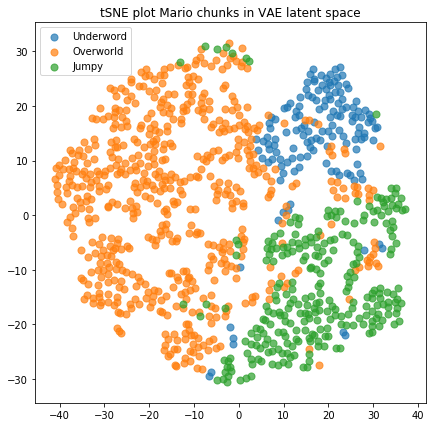

In [62]:
fig = plt.figure(figsize=(7, 7))

labels = ['Underword', 'Overworld', 'Jumpy']

for i in range(3):
    plt.scatter(
        tsne_features_sub[level_idxs_sub == i][X], 
        tsne_features_sub[level_idxs_sub == i][Y],
        label=labels[i],
        s=50, alpha=0.7
    )

plt.title('tSNE plot Mario chunks in VAE latent space')

plt.legend()
# plt.savefig('tSNE plot Mario chunks in VAE latent space.png')
plt.show()